In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
raw_data = pd.read_csv('FIFA_raw_data.csv')
df = raw_data.copy()
df = df.drop(['ID', 'LongName', 'photoUrl', 'playerUrl'], axis = 1)
df = df.rename(columns={'↓OVA':'OVA'})
df["Club"]=df["Club"].str.strip("\n\n\n\n")
df['Height'] = df['Height'].str.replace('cm', '')
def ft_to_cm(x):
    if "'" in x:
        parts = x.replace('"', '').split("'")
        feet = float(parts[0])
        inches = float(parts[1]) if parts[1] else 0
        cm = round((feet * 30.48) + (inches * 2.54), 0)
        return int(cm)
    else:
        return int(x)

df["Height"]=df["Height"].apply(ft_to_cm)
df["Height"].unique()
df['Weight'] = df['Weight'].str.replace('kg', '')
def lbs_to_kg(x):
    if "lbs" in x:
        lbs = x.replace("lbs", "")
        kg = round(int(lbs) / 2.2, 0)
        return int(kg)
    else:
        return int(x)

df['Weight'] = df['Weight'].apply(lbs_to_kg)
df.rename(columns={'Height':'Height(cm)','Weight':'Weight(kg)'},inplace =True)
def money(x):
    if "€" in x:
        x = x.replace("€", "")
    if "M" in x:
        x=x.replace("M", "")
        return int(float(x) * 1000000)
    elif "K" in x:
        x = x.replace("K", "")
        return int(float(x) * 1000)

    return int(x)

df['Value'] = df['Value'].apply(money)
df['Wage'] = df['Wage'].apply(money)
df['Release Clause'] = df['Release Clause'].apply(money)

df.rename(columns = {'Value':'Value (€)', "Wage":"Wage (€)"})

df['W/F'] = df['W/F'].str.replace("★", "")
df['SM'] = df['SM'].str.replace("★", "")
df['IR'] = df['IR'].str.replace("★", "")

df.rename(columns = {'W/F':'Weak Foot /5', "SM":"Skill Moves /5", "IR": "International Reputation /5"}, inplace = True)

def type(x):
    if "Free" in x:
        return "Free"
    if "Loan" in x:
        return "Loan"
    if "~" in x:
        return "Contract"
    else:
        return pd.NA

def start_time_contract(x):
    if "~" in x:
        return  int(x[:4])
    if "Loan" in x:
        x=x.strip(" On Loan")
        x= datetime.strptime(x, "%b %d, %Y")
        return x.date()
    else:
        return pd.NA

def end_time_contract(type,contract,loan):
    if type == "Contract":
        return int(contract[-4:])
    if type == "Loan":
        loan = datetime.strptime(loan, "%b %d, %Y")
        return loan.date()

    else:
        return pd.NA

df["Type of contract"] = df["Contract"].apply(type)
df["Start year"] = df["Contract"].apply(start_time_contract)
df["End year"] = df.apply(lambda row: end_time_contract(row["Type of contract"],row["Contract"],row["Loan Date End"] ), axis=1)

df["Attacking"]=round(df["Attacking"]/5,0)
df["Attacking"]=df["Attacking"].astype("int64")

df["Skill"]=df["Skill"]/5
df["Skill"]=df["Skill"].astype("int64")


df["Movement"]=df["Movement"]/5
df["Movement"]=df["Movement"].astype("int64")


df["Power"]=df["Power"]/5
df["Power"]=df["Power"].astype("int64")


df["Mentality"]=df["Mentality"]/6
df["Mentality"]=df["Mentality"].astype("int64")

df["Defending"]=df["Defending"]/3
df["Defending"]=df["Defending"].astype("int64")

df["Goalkeeping"] = df["Goalkeeping"]/5
df["Goalkeeping"] = df["Goalkeeping"].astype("int64")

df=df.rename(columns={"Attacking":"Attacking AVG", "Skill":"Skill AVG", "Movement":"Movement AVG",
                    "Power":"Power AVG", "Mentality":"Mentality AVG", "Defending":"Defending AVG", "Goalkeeping":"Goalkeeping AVG"} )

df = df.drop(['Hits'], axis=1)

df_columns = ['Name', 'Nationality', 'Age', 'OVA', 'POT', 'Club', 'Contract',
       'Positions', 'Height(cm)', 'Weight(kg)', 'Preferred Foot', 'BOV',
       'Best Position', 'Joined','Type of contract', 'Start year',
       'End year', 'Loan Date End', 'Value', 'Wage',
       'Release Clause', 'Attacking AVG', 'Crossing', 'Finishing',
       'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill AVG',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Movement AVG', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
       'Balance', 'Power AVG', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality AVG', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending AVG',
       'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeping AVG',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'Total Stats', 'Base Stats', 'Weak Foot /5',
       'Skill Moves /5', 'A/W', 'D/W', 'International Reputation /5', 'PAC',
       'SHO', 'PAS', 'DRI', 'DEF', 'PHY',]

df=df[df_columns]

df=df.drop(columns=['Loan Date End','Joined'])

df[['Weak Foot /5', 'Skill Moves /5', 'International Reputation /5']] = df[['Weak Foot /5', 'Skill Moves /5', 'International Reputation /5']]\
.apply(pd.to_numeric)

def find_field_position(x):
    if x == 'GK':
        return x
    elif x in ['CB', 'RB', 'LB', 'LWB', 'RWB']:
        return 'DEF'
    elif x in ['CAM', 'CDM', 'CM', 'LM', 'RM']:
        return 'MID'
    else:
        return 'ATT'

df['Field Position'] = df['Best Position'].apply(find_field_position)

col_names = ['Name', 'Nationality', 'Age', 'OVA', 'POT', 'Club', 'Contract',
       'Positions', 'Height(cm)', 'Weight(kg)', 'Preferred Foot', 'BOV',
       'Best Position', 'Field Position', 'Type of contract', 'Start year', 'End year', 'Value',
       'Wage', 'Release Clause', 'Attacking AVG', 'Crossing', 'Finishing',
       'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill AVG',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Movement AVG', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
       'Balance', 'Power AVG', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality AVG', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending AVG',
       'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeping AVG',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'Total Stats', 'Base Stats', 'Weak Foot /5',
       'Skill Moves /5', 'A/W', 'D/W', 'International Reputation /5', 'PAC',
       'SHO', 'PAS', 'DRI', 'DEF', 'PHY']

df = df[col_names]

df_preprocessed = df.copy()

# Adding the area of play column

What I want is to add an area of play column that shows if a player is a defender, midfielder, attacker etc.

Make a loop, use apply? df['Field Position'] = etc.

HAS NOW BEEN ADDED TO THE MASTER, NO NEED TO RERUN

In [ ]:
df['Best Position'].unique()

In [ ]:
def find_field_position(x):
    if x == 'GK':
        return x
    elif x in ['CB', 'RB', 'LB', 'LWB', 'RWB']:
        return 'DEF'
    elif x in ['CAM', 'CDM', 'CM', 'LM', 'RM']:
        return 'MID'
    else:
        return 'ATT'

# I hope I got it right...

In [ ]:
df['Field Position'] = df['Best Position'].apply(find_field_position)

In [ ]:
df['Field Position']

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
col_names = ['Name', 'Nationality', 'Age', 'OVA', 'POT', 'Club', 'Contract',
       'Positions', 'Height(cm)', 'Weight(kg)', 'Preferred Foot', 'BOV',
       'Best Position', 'Field Position', 'Type of contract', 'Start year', 'End year', 'Value',
       'Wage', 'Release Clause', 'Attacking AVG', 'Crossing', 'Finishing',
       'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill AVG',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Movement AVG', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
       'Balance', 'Power AVG', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality AVG', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending AVG',
       'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeping AVG',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'Total Stats', 'Base Stats', 'Weak Foot /5',
       'Skill Moves /5', 'A/W', 'D/W', 'International Reputation /5', 'PAC',
       'SHO', 'PAS', 'DRI', 'DEF', 'PHY']

In [ ]:
df = df[col_names]

In [ ]:
df[['Best Position', 'Field Position']].head(20)

# Exploratory Analysis

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Boxplot of Wage
plt.figure(figsize=(10, 6))
sns.boxplot(x='Wage', data=df)
plt.title('Box Plot of Wage')
plt.xlabel('Wage in Euros')
plt.show()

In [ ]:
#Scatter Plot of Overall vs Wage

plt.figure(figsize=(10, 6))
sns.scatterplot(x='OVA', y='Wage', data=df)
plt.title('OVA vs Wage')
plt.xlabel('Overall Rating (OVA)')
plt.ylabel('Wage')
plt.show()

In [ ]:
club_counts = df['Club'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=club_counts.index, y=club_counts.values)
plt.xticks(rotation=45)
plt.title('Top 10 Clubs by Number of Players')
plt.xlabel('Club')
plt.ylabel('Number of Players')
plt.show()

In [ ]:
sns.lineplot(x=df['Age'],y=df['POT'],color='green')
plt.title('Player Potential vs Age')

In [ ]:
# MY one all of my own of wage vs field position

plt.figure(figsize=(10, 6))
sns.barplot(x='Field Position', y='Wage', data=df)
plt.title('Field Position vs Average Wage')
plt.xlabel('Field Position')
plt.ylabel('Average Wage')
plt.show()

In [ ]:
position_in_order = ["GK", "LWB", "LB", "CB", "RB", "RWB", "CDM", "LM", "CM", "RM", "CAM", "LW", "CF", "RW", "ST"]

In [ ]:
plt.xticks(rotation=45)
sns.boxplot(data=df,x="Best Position",y="OVA",order=position_in_order)
plt.show()

In [ ]:
field_positions_in_order = ['GK', 'DEF', 'MID', 'ATT']
plt.xticks(rotation=45)
sns.boxplot(data=df,x="Field Position",y="Wage",order=field_positions_in_order)
plt.show()

#Ends up being a terribly useless graph as... well, most players get paid incredibly low compared to the outliers!

# Outlier Detection

In [ ]:
# Boxplot before outlier

sns.set(style="whitegrid")

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns #Selects only columns with numerical values

num_columns = 5 
num_rows = (len(numerical_columns) + num_columns - 1) // num_columns # Calculates number of rows (num_columns - 1 is there to account for the remainder

plt.figure(figsize=(num_columns * 3, num_rows * 3)) # I guess this is so there's room for each figure to take up 3*3 space

for i, column in enumerate(numerical_columns, 1): #Creates a value (column), and an index number for each value in the loop.
    plt.subplot(num_rows, num_columns, i) # with the given number of rows and columns, and the index i, it knows now where to put the chart
    sns.boxplot(x=df[column]) #Creates a boxplot of the values in the current column for each loop.
    plt.title(column) #Gives it a title of column
    plt.xlabel('') # No space, so gives it no value. 

plt.tight_layout()
plt.show()

# Explaining enumerate

Normally, when looping through an iterable, only the values are accessed. Enumerate creates pairs of count and element, instead of just the element (like an ID# for each one). i becomes the index number, and the var name (column) becomes the value. So it does this for the numerical_columns list, and gives the first index a value of one, as matplotlib uses index-1, not 0.

'i, column' are the two values being enumerated. First the index, then the value.

# Handling outliers

In [ ]:
df_outliers = df.copy()

In [ ]:
def handle_outliers_iqr(df_outliers, multiplier=1.5):
    numerical_columns = df_outliers.select_dtypes(include=['float64', 'int64']).columns

    for column in numerical_columns:
        Q1 = df_outliers[column].quantile(0.25)
        Q3 = df_outliers[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        outliers = df_outliers[(df_outliers[column] < lower_bound) | (df_outliers[column] > upper_bound)]
        #print(f"Outliers detected in '{column}': {outliers.index.tolist()}")

        df_outliers[column] = np.where(df_outliers[column] < lower_bound, lower_bound, df_outliers[column])
        df_outliers[column] = np.where(df_outliers[column] > upper_bound, upper_bound, df_outliers[column])

    return df_outliers

df_outliers = handle_outliers_iqr(df_outliers, multiplier=1.5)

for column in df_outliers.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df_outliers[column].quantile(0.25)
    Q3 = df_outliers[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    remaining_outliers = df_outliers[(df_outliers[column] < lower_bound) | (df_outliers[column] > upper_bound)]
    if not remaining_outliers.empty:
        print(f"Remaining outliers in '{column}': {remaining_outliers.index.tolist()}")
    else:
        print(f"No remaining outliers in '{column}'.")

In [ ]:
sns.set(style="whitegrid")

numerical_columns = df_outliers.select_dtypes(include=['float64', 'int64']).columns #Selects only columns with numerical values

num_columns = 5 
num_rows = (len(numerical_columns) + num_columns - 1) // num_columns # Calculates number of rows (num_columns - 1 is there to account for the remainder

plt.figure(figsize=(num_columns * 3, num_rows * 3)) # I guess this is so there's room for each figure to take up 3*3 space

for i, column in enumerate(numerical_columns, 1): #Creates a value (column), and an index number for each value in the loop.
    plt.subplot(num_rows, num_columns, i) # with the given number of rows and columns, and the index i, it knows now where to put the chart
    sns.boxplot(x=df_outliers[column]) #Creates a boxplot of the values in the current column for each loop.
    plt.title(column) #Gives it a title of column
    plt.xlabel('') # No space, so gives it no value. 

plt.tight_layout()
plt.show()

# Other Analysis

Just some final plots that I think will be interesting to see. A good opportunity to put into practice what I've learned and figure out how to resolve the multitude of mistakes I will undoubtedly make

In [ ]:
#Relationship between OVA and POT by Age

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['Age'], df['OVA'], df['POT'],
           c=df['POT'] - df['OVA'], cmap='viridis', s=20)

ax.set_xlabel('Age')
ax.set_ylabel('Overall Rating')
ax.set_zlabel('Potential Rating')
ax.set_title('Overall vs Potential by Age')

plt.show()

In [ ]:
pivot = df.pivot_table(index='OVA', columns='Age', values='POT', aggfunc='mean')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Average Potential'})
plt.title('Potential Rating by Age and Overall Rating')
plt.xlabel('Age')
plt.ylabel('Overall Rating')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from scipy.interpolate import griddata

# Extract relevant columns
data = df[['Age', 'OVA', 'POT']].dropna()

# Create grid
xi = np.linspace(data['OVA'].min(), data['OVA'].max(), 100)
yi = np.linspace(data['Age'].min(), data['Age'].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate potential values on the grid
zi = griddata((data['OVA'], data['Age']), data['POT'], (xi, yi), method='cubic')

plt.figure(figsize=(12, 7))
contour = plt.contourf(xi, yi, zi, levels=20, cmap='coolwarm')
plt.colorbar(contour, label='Potential Rating')
plt.xlabel('OVA')
plt.ylabel('Age')
plt.title('Contour Plot of Potential Rating by Age and Overall')
plt.show()

In [ ]:
df['Growth_Margin'] = df['POT'] - df['OVA']
pivot = df.pivot_table(index='OVA', columns='Age', values='Growth_Margin', aggfunc='mean')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='RdBu_r', center=0, cbar_kws={'label': 'Growth Margin (Potential - Overall)'})
plt.title('Growth Margin by Age and Overall Rating')
plt.xlabel('Age')
plt.ylabel('Overall Rating')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# Past Peak Performance

Would be interesting to look at the fall from BOVA to current in players past their peak

1. Figuring out where the peak is (Can actually see fairly well from the above graph that growth is practically non-existant from 28 and up) - Actually there's an easier way to do this!
2. Have a new df for players past the peak.
3. Difference between BOVA and OVA by age

In [ ]:
#Where BOV - OVA > 0, that's past peak!
df_pp = df.copy()
df_pp = df[df['BOV'] - df['OVA'] > 0]

In [ ]:
df_pp[['POT','BOV','OVA']].head(20)

In [ ]:
#Seems as though some players still have higher POT than their OVA, indicating they may not have peaked

df_pp = df_pp[df_pp['POT'] - df_pp['OVA'] <= 0]
#813 rows left

In [ ]:
df_pp['OVA Diff'] = df_pp['BOV'] - df_pp['OVA']

In [ ]:
df_pp[['OVA Diff','BOV','OVA']].head()

In [ ]:
df_pp['Age'].min()

In [ ]:
df_err = df_pp.copy()

df_err = df_err[df_err['Age'] <= 25]

In [ ]:
df_err

In [ ]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df_pp30 = df_pp.copy()

df_pp30 = df_pp30[df_pp30['Age'] < 30]
df_pp30

#Turns out that Brazilian league teams don't grant FIFA rights, so all players in a Brazilian club will be generated.

In [48]:
brazil_clubs = ['Athletico-PR','Atlético Mineiro','Atlético-GO','Bahia','Ceará SC','Chapecoense','Cuiabá','Fluminense',\
'Fortaleza','Grêmio','Internacional','Juventude','Santos']

pp_brazil = df_pp.copy()
pp_brazil = pp_brazil[pp_brazil['Club'].isin(brazil_clubs)]
pp_brazil.head(20)

,Name,Nationality,Age,OVA,POT,Club,Contract,Positions,Height(cm),Weight(kg),Preferred Foot,BOV,Best Position,Field Position,Type of contract,Start year,End year,Value,Wage,Release Clause,Attacking AVG,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Skill AVG,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Movement AVG,Acceleration,Sprint Speed,Agility,Reactions,Balance,Power AVG,Shot Power,Jumping,Stamina,Strength,Long Shots,Mentality AVG,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defending AVG,Marking,Standing Tackle,Sliding Tackle,Goalkeeping AVG,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total Stats,Base Stats,Weak Foot /5,Skill Moves /5,A/W,D/W,International Reputation /5,PAC,SHO,PAS,DRI,DEF,PHY,Growth_Margin,OVA Diff
146,Ronaldo Cabrais,Brazil,28,83,83,Grêmio,2019 ~ 2023,"CAM, RM",177,75,Right,84,RM,MID,Contract,2019,2023,36500000,49000,49400000,76,83,74,64,83,76,82,85,86,78,82,83,83,90,87,86,84,71,77,82,69,88,68,78,57,62,40,82,83,77,81,30,24,35,33,13,12,12,13,15,13,2098,439,4,4,Medium,Low,1,88,77,83,84,35,72,0,1
538,Luimo Boas Santos,Brazil,20,79,79,Santos,2019 ~ 2023,ST,176,73,Right,80,CF,ATT,Contract,2019,2023,20000000,27000,27600000,70,42,81,76,74,76,71,82,79,60,56,81,81,86,80,82,85,73,77,75,87,79,63,82,49,43,20,82,75,74,73,22,27,20,19,9,9,12,8,10,9,1907,400,4,4,High,Medium,1,83,79,65,81,28,64,0,1
2156,José Mirazar,Brazil,24,74,74,Grêmio,2019 ~ 2023,"CAM, LM, LW",180,74,Left,75,LM,MID,Contract,2019,2023,4900000,22000,11400000,70,77,64,68,75,64,76,79,77,76,74,76,72,73,72,76,74,67,64,63,44,82,67,66,51,34,45,75,76,76,67,25,32,23,22,10,9,9,8,8,16,1847,388,3,3,Medium,Medium,1,72,65,76,77,35,63,0,1
3159,Pietrson Mendes,Brazil,24,72,72,Bahia,2019 ~ 2023,"CAM, ST",173,64,Left,73,LW,ATT,Contract,2019,2023,2700000,9000,6500000,69,76,66,56,76,72,72,72,77,76,63,75,78,75,84,80,67,84,61,74,56,68,43,68,49,45,47,68,68,68,76,41,28,51,44,10,11,13,13,9,7,1880,389,3,3,Medium,Medium,1,80,69,73,74,43,50,0,1
3429,Kauã Abranches,Brazil,24,72,72,Fortaleza,2019 ~ 2023,"CAM, RM, RB",177,70,Right,74,RM,MID,Contract,2019,2023,2700000,9000,6500000,61,72,64,43,70,58,62,72,49,60,58,73,80,87,81,79,81,75,64,63,58,77,59,66,52,49,66,77,71,53,68,49,34,58,57,13,8,10,12,20,19,1879,401,4,3,High,Medium,1,84,64,67,74,51,61,0,2
3537,Santi da Bruma,Brazil,24,72,72,Bahia,2019 ~ 2023,"ST, RM",172,67,Right,76,RW,ATT,Contract,2019,2023,2700000,10000,6700000,73,73,73,67,76,77,72,74,84,60,70,75,85,88,85,88,81,83,68,61,80,80,50,69,49,45,45,70,68,71,70,30,27,33,32,12,15,13,12,10,11,1946,401,5,3,High,Low,1,86,70,73,77,37,58,0,4
4146,Gus Outomouro,Brazil,24,71,71,Internacional,2019 ~ 2023,"ST, LM",175,73,Right,72,CF,ATT,Contract,2019,2023,2200000,16000,5100000,70,62,74,67,73,73,67,70,71,60,62,74,74,72,70,79,73,76,69,75,71,68,63,69,45,50,23,68,73,56,71,23,24,25,20,10,8,9,16,11,7,1792,374,3,3,Medium,Medium,1,71,72,68,73,28,62,0,1
4193,Carleto Costinha,Brazil,28,71,71,Fluminense,2019 ~ 2023,"CAM, ST, RM",175,69,Right,72,RM,MID,Contract,2019,2023,1900000,16000,4600000,65,72,68,47,75,61,70,71,71,73,63,74,77,86,79,78,64,78,57,61,58,64,53,51,50,42,43,71,70,77,73,36,19,52,38,11,8,14,11,14,9,1815,381,4,3,Medium,Low,1,82,63,71,73,38,54,0,1
4833,Paulolettinho,Brazil,24,70,70,Fortaleza,2019 ~ 2023,"CAM, RM, RW",181,80,Right,71,RM,MID,Contract,2019,2023,1800000,7000,3800000,63,74,61,44,72,62,67,75,63,64,66,71,71,79,79,71,66,60,64,61,70,62,75,55,43,31,45,66,71,45,72,26,26,26,27,11,12,12,11,12,10,1724,375,3,3,High,Medium,1,79,59,70,72,32,63,0,1
5018,Eltildo Bessa,Brazil,24,70,70,Fortaleza,2019 ~ 2023,"ST, CF, LW",165,62,Left,72,CF,ATT,Contract,2019,2023,1900000,8000,3800000,62,40,71,61,61,75,66,73,76,64,43,75,84,85,87,87,78,87,58,62,69,70,30,63,44,42,26,77,65,59,79,28,30,25,29,10,12,9,11,12,8,1762,361,3,3,High,Low,1,86,68,56,76,31,44,0,2


In [49]:
df_pp = df_pp[~df_pp['Club'].isin(brazil_clubs)]
df_pp.head()

,Name,Nationality,Age,OVA,POT,Club,Contract,Positions,Height(cm),Weight(kg),Preferred Foot,BOV,Best Position,Field Position,Type of contract,Start year,End year,Value,Wage,Release Clause,Attacking AVG,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Skill AVG,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Movement AVG,Acceleration,Sprint Speed,Agility,Reactions,Balance,Power AVG,Shot Power,Jumping,Stamina,Strength,Long Shots,Mentality AVG,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defending AVG,Marking,Standing Tackle,Sliding Tackle,Goalkeeping AVG,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total Stats,Base Stats,Weak Foot /5,Skill Moves /5,A/W,D/W,International Reputation /5,PAC,SHO,PAS,DRI,DEF,PHY,Growth_Margin,OVA Diff
117,W. Ben Yedder,France,29,84,84,AS Monaco,2019 ~ 2024,ST,170,68,Right,85,CF,ATT,Contract,2019,2024,42000000,90000,58900000,80,74,88,74,82,84,79,87,80,76,66,87,86,86,82,91,86,89,72,83,79,68,63,71,58,55,44,90,80,80,84,31,34,33,26,8,6,13,9,7,7,2080,433,5,4,High,High,2,84,83,77,87,39,63,0,1
123,J. Iličić,Slovenia,32,84,84,Atalanta,2017 ~ 2022,"CF, ST",190,79,Left,85,CAM,MID,Contract,2017,2022,34000000,90000,42500000,79,82,85,58,86,83,84,88,85,85,74,88,72,71,69,71,84,66,70,88,34,69,74,89,59,58,46,85,87,78,80,37,53,32,26,10,13,13,8,12,6,2046,436,4,4,Medium,Medium,3,70,86,84,85,43,68,0,1
200,Allan,Brazil,29,83,83,Everton,2020 ~ 2023,"CM, CDM",175,74,Right,85,CDM,MID,Contract,2020,2023,35500000,115000,47500000,69,70,74,59,84,56,71,82,65,49,79,83,79,77,69,78,88,86,75,73,67,92,78,69,65,90,88,79,80,53,85,87,87,88,86,8,13,13,5,5,8,2173,471,3,4,Medium,High,2,73,71,77,82,85,83,0,2
203,R. Nainggolan,Belgium,32,83,83,Inter,2018 ~ 2022,"CAM, CM, CF",176,65,Right,85,CDM,MID,Contract,2018,2022,29000000,125000,34000000,73,73,75,59,85,75,78,83,73,68,82,84,77,71,71,75,85,83,82,86,74,89,75,89,66,88,86,84,80,63,84,86,83,86,90,11,11,11,14,8,11,2270,478,3,3,High,High,3,71,80,80,83,83,81,0,2
257,Canales,Spain,29,82,82,Real Betis,2018 ~ 2023,"CM, LM, RM",176,65,Left,83,CAM,MID,Contract,2018,2023,29500000,36000,45200000,71,79,82,46,83,63,82,83,82,81,82,84,79,78,78,82,83,76,68,78,39,76,68,81,64,63,77,85,87,74,79,62,60,71,55,13,15,12,16,13,12,2144,457,3,4,High,Medium,2,78,80,83,83,65,68,0,1


In [58]:
df_pp['Age'].min()

20

In [50]:
df_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 792 entries, 117 to 18969
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Name                         792 non-null    object
 1   Nationality                  792 non-null    object
 2   Age                          792 non-null    int64 
 3   OVA                          792 non-null    int64 
 4   POT                          792 non-null    int64 
 5   Club                         792 non-null    object
 6   Contract                     792 non-null    object
 7   Positions                    792 non-null    object
 8   Height(cm)                   792 non-null    int64 
 9   Weight(kg)                   792 non-null    int64 
 10  Preferred Foot               792 non-null    object
 11  BOV                          792 non-null    int64 
 12  Best Position                792 non-null    object
 13  Field Position               792 non

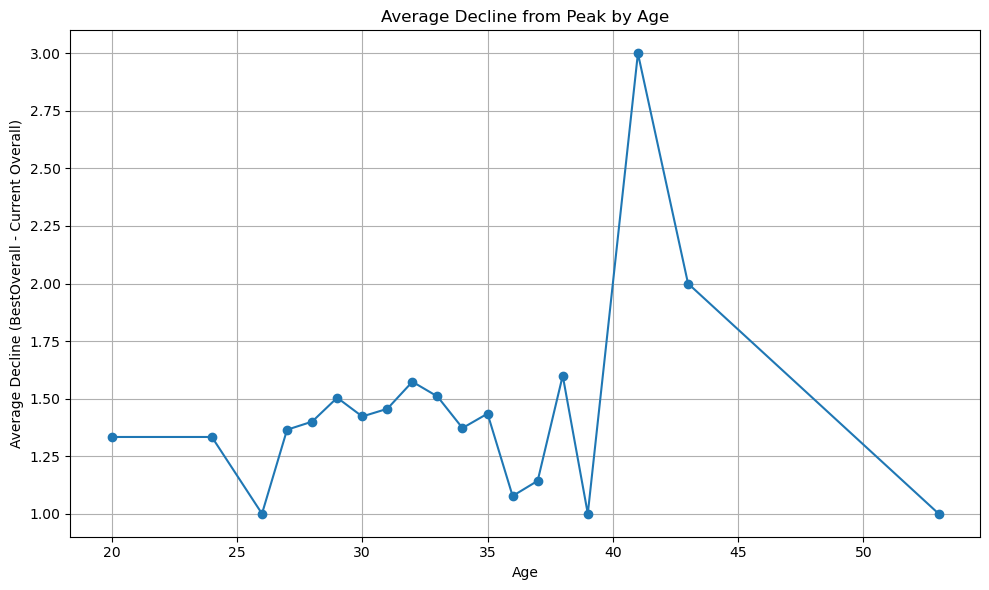

In [52]:
age_decline = df_pp.groupby('Age')['OVA Diff'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(age_decline['Age'], age_decline['OVA Diff'], marker='o')
plt.title('Average Decline from Peak by Age')
plt.xlabel('Age')
plt.ylabel('Average Decline (BestOverall - Current Overall)')
plt.grid(True)
plt.tight_layout()
plt.show()

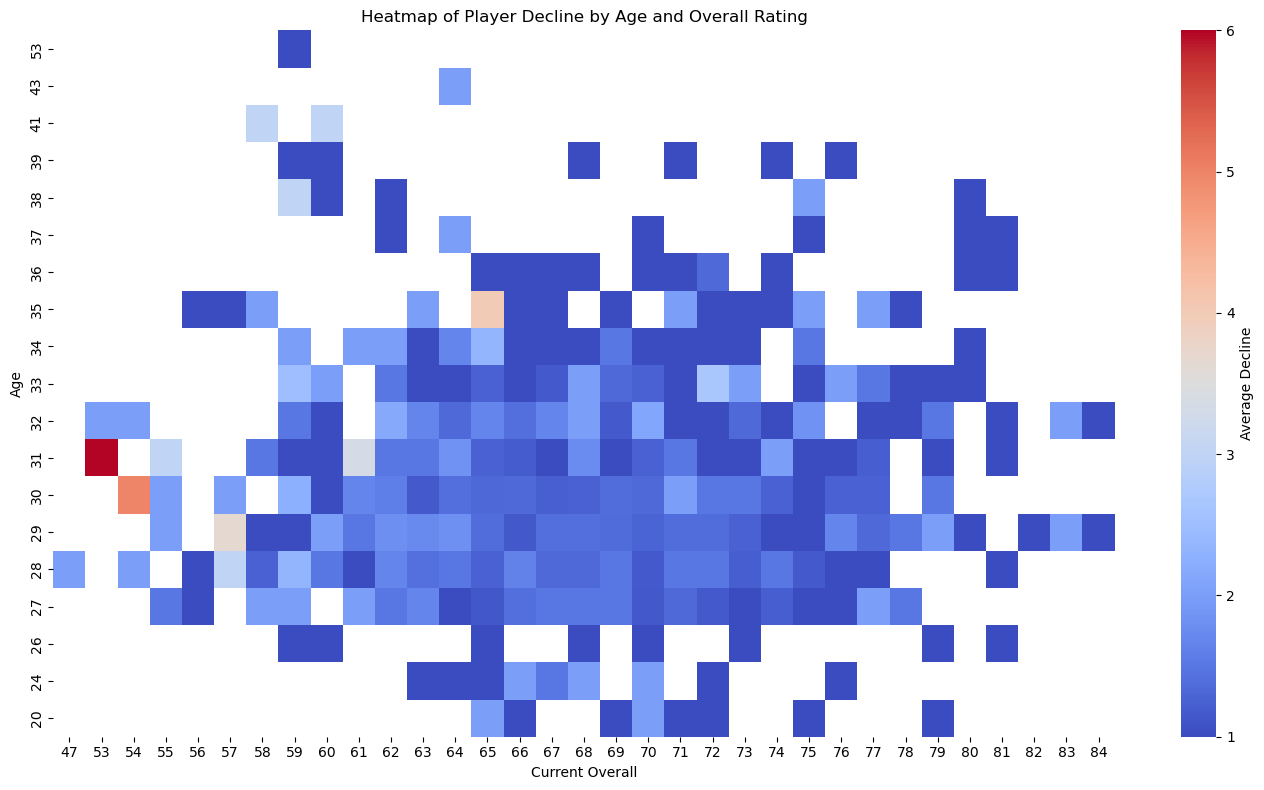

In [57]:
pivot = df_pp.pivot_table(index='Age', columns='OVA', values='OVA Diff', aggfunc='mean')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='coolwarm', cbar_kws={'label': 'Average Decline'})
plt.title('Heatmap of Player Decline by Age and Overall Rating')
plt.xlabel('Current Overall')
plt.ylabel('Age')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Past Peak Prediction

I may have to shelve this for now, as it's a bit advanced for me, but I'd very much like to return to it after a bit more study and look at how to predict the OVA of players at a certain age. There's still a little I could do now though.

In [60]:
#Removing GKs as they have a vastly different Age profile
sans_gk = df.copy()
sans_gk = sans_gk[sans_gk['Field Position'] != 'GK']
sans_gk['Field Position'].unique()

array(['ATT', 'MID', 'DEF'], dtype=object)

In [61]:
sans_gk.head()

,Name,Nationality,Age,OVA,POT,Club,Contract,Positions,Height(cm),Weight(kg),Preferred Foot,BOV,Best Position,Field Position,Type of contract,Start year,End year,Value,Wage,Release Clause,Attacking AVG,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Skill AVG,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Movement AVG,Acceleration,Sprint Speed,Agility,Reactions,Balance,Power AVG,Shot Power,Jumping,Stamina,Strength,Long Shots,Mentality AVG,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defending AVG,Marking,Standing Tackle,Sliding Tackle,Goalkeeping AVG,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total Stats,Base Stats,Weak Foot /5,Skill Moves /5,A/W,D/W,International Reputation /5,PAC,SHO,PAS,DRI,DEF,PHY,Growth_Margin
0,L. Messi,Argentina,33,93,93,FC Barcelona,2004 ~ 2021,"RW, ST, CF",170,72,Left,93,RW,ATT,Contract,2004,2021,103500000,560000,138400000,86,85,95,70,91,88,94,96,93,94,91,96,90,91,80,91,94,95,77,86,68,72,69,94,57,44,40,93,95,75,96,30,32,35,24,10,6,11,15,14,8,2231,466,4,4,Medium,Low,5,85,92,91,95,38,65,0
1,Cristiano Ronaldo,Portugal,35,92,92,Juventus,2018 ~ 2022,"ST, LW",187,83,Right,92,ST,ATT,Contract,2018,2022,63000000,220000,75900000,87,84,95,90,82,86,82,88,81,76,77,92,86,87,91,87,95,71,88,94,95,84,78,93,58,63,29,95,82,84,95,28,28,32,24,11,7,11,15,14,11,2221,464,4,5,High,Low,5,89,93,81,89,35,77,0
3,K. De Bruyne,Belgium,29,91,91,Manchester City,2015 ~ 2023,"CAM, CM",181,70,Right,91,CAM,MID,Contract,2015,2023,129000000,370000,161000000,81,94,82,55,94,82,88,88,85,83,93,92,79,77,76,78,91,76,81,91,63,89,74,91,68,76,66,88,94,84,91,62,68,65,53,11,15,13,5,10,13,2304,485,5,4,High,High,4,76,86,93,88,64,78,0
4,Neymar Jr,Brazil,28,91,91,Paris Saint-Germain,2017 ~ 2022,"LW, CAM",175,68,Right,91,LW,ATT,Contract,2017,2022,132000000,270000,166500000,82,85,87,62,87,87,89,95,88,89,81,95,90,94,89,96,91,83,71,80,62,81,50,84,59,51,36,87,90,92,93,31,35,30,29,11,9,9,15,15,11,2175,451,5,5,High,Medium,5,91,85,86,94,36,59,0
5,R. Lewandowski,Poland,31,91,91,FC Bayern München,2014 ~ 2023,ST,184,80,Right,91,ST,ATT,Contract,2014,2023,111000000,240000,132000000,85,71,94,85,84,89,81,85,79,85,70,88,81,77,78,77,93,82,84,89,84,76,86,85,65,81,49,94,79,88,88,32,35,42,19,10,15,6,12,8,10,2195,457,4,4,High,Medium,4,78,91,78,85,43,82,0


In [64]:
only_gk = df.copy()
only_gk = only_gk[only_gk['Field Position'] == 'GK']
only_gk['Field Position'].unique()

array(['GK'], dtype=object)

In [63]:
df['Field Position'].unique()

array(['ATT', 'GK', 'MID', 'DEF'], dtype=object)

In [67]:
#Fields for distance from POT where > 0, and distance from BOV where > 0)

sans_gk['Distance from POT'] = sans_gk['POT'] - sans_gk['OVA']
sans_gk['Distance from POT'] = sans_gk['Distance from POT'].clip(lower=0)

sans_gk['Decline'] = sans_gk['BOV'] - sans_gk['OVA']
sans_gk['Decline'] = sans_gk['Decline'].clip(lower=0)

In [69]:
sans_gk['Distance from POT'].unique()

array([ 0,  5,  1,  2,  6,  3,  4,  8,  7, 12, 13, 11,  9, 10, 14, 16, 15,
       17, 18, 19, 20, 21, 22, 26, 23, 25, 24], dtype=int64)

In [70]:
sans_gk['Decline'].unique()



array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)